***
In this notebook i will be demonstarting Latent Dirichlet Allocation(LDA) for topic modelling. I will be using the Amazon fine food reviews dataset from Kaggle(https://www.kaggle.com/snap/amazon-fine-food-reviews) for performing LDA based topic modelling
I will be using the gensim package for LDA topic modelling and pyLDAvis for visualization of LDA topic model
***

In [48]:
import pandas as pd
import numpy as np

import re
import string

import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [49]:
review_data= pd.read_csv("C:\\AmazonReviews\\Reviews.csv")
print(review_data.head(2))
print(len(review_data))
print('Unique Products')
print(len(review_data.groupby('ProductId')))
print('Unique Users')
print(len(review_data.groupby('UserId')))

   Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
568454
Unique Products
74258
Unique Users
256059


In [51]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

In [ ]:
import nltk
nltk.download('stopwords') # run this one time

In [53]:
review_data.dropna(axis = 0, how ='any',inplace=True) 






review_data['Text'] = review_data['Text'].apply(clean_text)
review_data['Num_words_text'] = review_data['Text'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['Score'].value_counts())
print(len(review_data))
print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()

mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
df_sampled = df_short_reviews.groupby('Score').apply(lambda x: x.sample(n=20000)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))



#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()


-------Dataset --------
5    363111
4     80655
1     52264
3     42638
2     29743
Name: Score, dtype: int64
568411
-------------------------
No of Short reviews
373281


***
Let us pre-process the data
***

In [54]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df_sampled['Text']=df_sampled['Text'].apply(remove_stopwords)



In [55]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [56]:
 
text_list=df_sampled['Text'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

love stroopwafels tried sorts kind come shipper stroopie stroopwafels nice brand instead count advertised arrived fancy blue need even sticker says count either someone embezzling stroopwafels misleadingly advertised aware read count makes price point pretty different
['love', 'stroopwafel', 'sort', 'shipper', 'stroopie', 'nice', 'brand', 'fancy', 'blue', 'need', 'sticker', 'stroopwafel', 'aware', 'read', 'count', 'price', 'point', 'different']


***
Create vocabulary dictionary and document term matrix
***

In [57]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [58]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [59]:
lda_model.print_topics()

[(0,
  '0.036*"flavor" + 0.033*"chip" + 0.028*"snack" + 0.028*"good" + 0.026*"great" + 0.024*"salt" + 0.017*"nice" + 0.016*"candy" + 0.015*"perfect" + 0.014*"little"'),
 (1,
  '0.078*"product" + 0.053*"free" + 0.025*"gluten" + 0.018*"yummy" + 0.017*"cracker" + 0.017*"snack" + 0.011*"package" + 0.010*"pretzel" + 0.010*"shipping" + 0.010*"banana"'),
 (2,
  '0.047*"sauce" + 0.035*"cereal" + 0.032*"good" + 0.027*"cheese" + 0.021*"pasta" + 0.017*"fresh" + 0.017*"seed" + 0.015*"beef" + 0.014*"texture" + 0.013*"taste"'),
 (3,
  '0.041*"product" + 0.039*"time" + 0.031*"order" + 0.028*"great" + 0.018*"good" + 0.016*"small" + 0.014*"package" + 0.013*"size" + 0.013*"bag" + 0.013*"soup"'),
 (4,
  '0.024*"bread" + 0.022*"time" + 0.018*"product" + 0.018*"year" + 0.014*"ginger" + 0.013*"clean" + 0.013*"pill" + 0.012*"stomach" + 0.011*"mild" + 0.011*"week"'),
 (5,
  '0.091*"food" + 0.030*"treat" + 0.024*"dog" + 0.020*"good" + 0.014*"great" + 0.014*"cat" + 0.014*"healthy" + 0.013*"meal" + 0.013*"little

In [60]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.141351  0.047873       1        1  16.145686
5      0.037246  0.053409       2        1  12.615354
3      0.173563  0.021284       3        1  12.407233
0     -0.144942  0.014901       4        1  11.442962
9     -0.130926  0.036637       5        1  11.124016
8     -0.208080 -0.020109       6        1   9.167505
6      0.055318 -0.236970       7        1   7.714573
1      0.270478 -0.168272       8        1   6.810434
4      0.192866  0.298452       9        1   6.712845
2     -0.104172 -0.047204      10        1   5.859394, topic_info=        Term          Freq         Total Category  logprob  loglift
211   coffee  30007.000000  30007.000000  Default  30.0000  30.0000
384     food  21620.000000  21620.000000  Default  29.0000  29.0000
28     price  13131.000000  13131.000000  Default  28.0000  28.0000
98     store  12459.000000  12459.000000  Default  27.0000  27.0000
50   product  30629.000000  30629.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
540     easy    881.687870   6233.924390  Topic10  -4.8335   0.8812
144    tasty    824.772711   4953.834953  Topic10  -4.9002   1.0443
222   little    939.906737  14132.219849  Topic10  -4.7695   0.1267
16      year    884.650617  10844.594123  Topic10  -4.8301   0.3309
184    piece    737.296305   3062.060625  Topic10  -5.0123   1.4133

[548 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1224      9  0.997894      adult
1982      2  0.999216  afternoon
1963      2  0.999064    allergy
844       6  0.999464     almond
3305      7  0.997322       alot
...     ...       ...        ...
16       10  0.081607       year
940       9  0.996954      yeast
17        8  0.998159     yellow
3332      8  0.999496     yogurt
1137      8  0.999393      yummy

[822 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 4, 1, 10, 9, 7, 2, 5, 3])

In [61]:

print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -8.661281920727216

Coherence Score:  0.41794426803997153


***
Method to find optimal number of topics
Code from:https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore
***

In [62]:


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [63]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

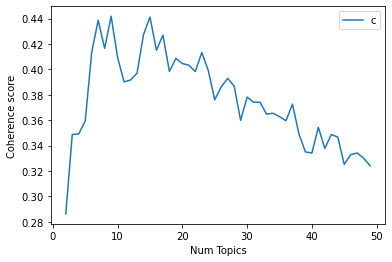

In [64]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores


In [65]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2863
Num Topics = 3  has Coherence Value of 0.3488
Num Topics = 4  has Coherence Value of 0.3492
Num Topics = 5  has Coherence Value of 0.3594
Num Topics = 6  has Coherence Value of 0.4134
Num Topics = 7  has Coherence Value of 0.4387
Num Topics = 8  has Coherence Value of 0.4166
Num Topics = 9  has Coherence Value of 0.4418
Num Topics = 10  has Coherence Value of 0.4094
Num Topics = 11  has Coherence Value of 0.3902
Num Topics = 12  has Coherence Value of 0.3917
Num Topics = 13  has Coherence Value of 0.397
Num Topics = 14  has Coherence Value of 0.4273
Num Topics = 15  has Coherence Value of 0.4412
Num Topics = 16  has Coherence Value of 0.415
Num Topics = 17  has Coherence Value of 0.427
Num Topics = 18  has Coherence Value of 0.3984
Num Topics = 19  has Coherence Value of 0.4086
Num Topics = 20  has Coherence Value of 0.4046
Num Topics = 21  has Coherence Value of 0.4033
Num Topics = 22  has Coherence Value of 0.3983
Num Topics = 23  has Coh

In [66]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.080*"chocolate" + 0.050*"cookie" + 0.034*"butter" + 0.031*"peanut" + 0.020*"milk" + 0.019*"taste" + 0.018*"great" + 0.016*"flavor" + 0.016*"good" + 0.014*"oatmeal"'),
 (1,
  '0.036*"chip" + 0.025*"salt" + 0.025*"good" + 0.024*"flavor" + 0.018*"great" + 0.014*"product" + 0.013*"store" + 0.011*"love" + 0.011*"fresh" + 0.010*"time"'),
 (2,
  '0.039*"treat" + 0.025*"dog" + 0.021*"time" + 0.020*"small" + 0.018*"product" + 0.015*"great" + 0.014*"size" + 0.013*"little" + 0.011*"year" + 0.011*"large"'),
 (3,
  '0.129*"coffee" + 0.047*"flavor" + 0.031*"good" + 0.027*"strong" + 0.021*"taste" + 0.015*"vanilla" + 0.013*"bean" + 0.013*"blend" + 0.013*"great" + 0.012*"green"'),
 (4,
  '0.048*"water" + 0.027*"drink" + 0.021*"taste" + 0.020*"bottle" + 0.019*"bread" + 0.017*"flavor" + 0.015*"energy" + 0.012*"cold" + 0.012*"product" + 0.012*"good"'),
 (5,
  '0.036*"good" + 0.031*"sweet" + 0.031*"sugar" + 0.028*"flavor" + 0.024*"snack" + 0.023*"taste" + 0.018*"great" + 0.017*"fruit" + 0.017*"ca

In [67]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.151518 -0.061432       1        1  15.582293
5     -0.102664  0.148708       2        1  12.897932
3     -0.173452 -0.177889       3        1  12.457369
1      0.048342 -0.018348       4        1  12.130062
2      0.210840 -0.026275       5        1  11.123561
6     -0.005811 -0.101921       6        1  10.470415
7      0.126547  0.158344       7        1  10.009680
4     -0.078110 -0.065762       8        1   8.501475
0     -0.177210  0.144577       9        1   6.827212, topic_info=          Term          Freq         Total Category  logprob  loglift
211     coffee  30666.000000  30666.000000  Default  30.0000  30.0000
384       food  22000.000000  22000.000000  Default  29.0000  29.0000
458  chocolate  10373.000000  10373.000000  Default  28.0000  28.0000
28       price  14366.000000  14366.000000  Default  27.0000  27.0000
229      water   8868.000000   8868.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
3         good   2027.261394  45320.222605   Topic9  -4.1538  -0.4228
24        love   1072.239594  13833.032820   Topic9  -4.7907   0.1269
462      sweet    932.429657   9482.645531   Topic9  -4.9304   0.3648
26        nice    885.644819   8066.596487   Topic9  -4.9819   0.4751
144      tasty    821.488988   5226.316256   Topic9  -5.0571   0.8339

[655 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2666      1  0.996344    addicted
3196      5  0.999092   addictive
3581      2  0.997750  affordable
3824      2  0.998462       agave
2793      8  0.996450     alcohol
...     ...       ...         ...
1137      3  0.018325       yummy
1137      4  0.286923       yummy
1137      6  0.043457       yummy
1137      9  0.370172       yummy
3227      7  0.997568        zuke

[1676 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 4, 2, 3, 7, 8, 5, 1])